In [43]:
import matplotlib.pyplot as plt

import traceback
import numpy as np
import tushare as ts
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D  #绘制三D图形

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import FeatureHasher, DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from lutils.stock import LTdxHq

In [4]:
# 获取股票基本信息，包括 PE、PB 值
ts.set_token('42731ca565c5d019007ef5cd7db7808757b2ea3fdbfb31d4f7b61444b')
pro = ts.pro_api()

df_base = pro.stock_basic() # ts.get_stock_basics()
# df_base['code'] = df_base.index

# 获取股票当天数据，包括当前股价
df_todays = ts.get_today_all()
# df_todays['code'] = df_todays.index

df_roe = ts.get_report_data(2021, 3)
# df_roe['code'] = df_roe.index

[Getting data:]###################################################本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
[Getting data:]###############################################################################

In [10]:
# df = pro.daily_basic(ts_code='', trade_date='20211116')

In [6]:
df_base['code'] = df_base['ts_code'].str.slice(stop=-3)
df_roe = df_roe.drop_duplicates()

In [7]:
# 整合股价与 PE、PB 数据
df = pd.merge(df_todays, df_base, how='left', on=['code'])
df = pd.merge(df, df_roe, how='left', on=['code'])
roe_describe = df['roe'].describe() # ?

df.dropna()
result = df[(0 < df['pb']) 
            & (df['pb'] < 8)
            & (-20 < df['roe']) 
            & (df['roe'] < 30) 
            & (0 < df['trade']) 
            & (df['trade'] < 70)
            & (-100<df['per']) 
            & (df['per']<200)]

# result = df[(-100<df['per']) & (df['per']<200) 
#             &(0<df['pb_x'])&(df['pb_x']<10)
# #              &(roe_describe['25%']<df['roe'])&(df['roe']<roe_describe['75%'])
#              &(0<df['trade'])&(df['trade']<100)]

# result = df[(-100<df['per']) & (df['per']<200) 
#             &(0<df['pb'])&(df['pb']<8)
#               &(roe_describe['25%']<df['roe'])&(df['roe']<roe_describe['75%'])
#              &(0<df['trade'])&(df['trade']<100)]

# X = result[['pb', 'roe', 'trade', 'code', 'industry', 'market']]

In [8]:
df.columns

Index(['code', 'name_x', 'changepercent', 'trade', 'open', 'high', 'low',
       'settlement', 'volume', 'turnoverratio', 'amount', 'per', 'pb',
       'mktcap', 'nmc', 'ts_code', 'symbol', 'name_y', 'area', 'industry',
       'market', 'list_date', 'name', 'eps', 'eps_yoy', 'bvps', 'roe', 'epcf',
       'net_profits', 'profits_yoy', 'distrib', 'report_date'],
      dtype='object')

In [9]:
df

,code,name_x,changepercent,trade,open,high,low,settlement,volume,turnoverratio,...,name,eps,eps_yoy,bvps,roe,epcf,net_profits,profits_yoy,distrib,report_date
0,873169,七丰精工,-0.752,6.60,6.56,6.74,6.53,6.65,474018,2.03102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,872925,锦好医疗,1.447,16.13,16.15,16.15,15.88,15.90,34996,0.20626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,871981,晶赛科技,-1.170,18.59,18.73,19.09,18.42,18.81,273970,1.29720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,871970,大禹生物,-0.611,9.76,9.83,9.83,9.76,9.82,333588,1.76785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,871857,泓禧科技,-0.729,9.53,9.55,9.59,9.50,9.60,36992,0.17169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4913,600087,退市长油,0.000,0.00,0.00,0.00,0.00,0.00,0,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4914,600083,*ST博信,-4.045,10.20,10.50,10.59,10.16,10.63,3718200,1.63084,...,*ST博信,-0.05,-41.05,NaN,NaN,NaN,-1211.88,-41.08,NaN,10-30
4915,600078,*ST澄星,3.141,12.15,11.88,12.34,11.65,11.78,20920883,3.15752,...,*ST澄星,0.14,1300.00,NaN,NaN,NaN,9290.62,1525.32,NaN,10-30
4916,600071,凤凰光学,-2.903,17.73,18.12,18.45,17.38,18.26,29165791,12.28176,...,凤凰光学,0.04,1131.03,NaN,1.95,NaN,1004.72,1136.73,NaN,10-26


In [51]:
result.shape

(2695, 32)

In [45]:
result.code.unique().shape

(1516,)

In [46]:
ddf = pd.read_pickle('d:/ddf_.pkl').dropna()

In [47]:
ddf.tic.unique().shape

(2395,)

In [10]:
ddf[ddf.tic == '000002']

,open,close,high,low,volume,amount,tic,date,day


In [230]:
# hasher = FeatureHasher(input_type='string')
# c = hasher.transform(result['name'])

# vec = DictVectorizer()
# vec.fit_transform(result['name'].values).toarray()

# vectorizer = CountVectorizer()
# vectors = vectorizer.fit_transform(result['name']).toarrayay()

# freq   = CountVectorizer()
# onehot = Binarizer()
# corpus = onehot.fit_transform(freq.fit_transform(result['name']).toarray())

# tfidf  = TfidfVectorizer()
# corpus = tfidf.fit_transform(result['industry'])

In [2]:
result = pd.read_pickle('d:/d.pkl')

In [3]:
columns = ['pb', 'roe', 'trade']# ['pb', 'roe', 'per'] # ['pb', 'roe', 'trade']

In [4]:
scaler = MinMaxScaler()
scaler.fit(result[columns])
X = pd.DataFrame(scaler.transform(result[columns]), columns=columns)

In [5]:
# kmeans = KMeans(n_clusters=10)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

model = SpectralClustering(n_clusters=7, affinity='nearest_neighbors', assign_labels='kmeans')
# model = DBSCAN(eps=0.6, min_samples=10)
# model = AffinityPropagation(random_state=5)
y_kmeans = model.fit_predict(X[columns])

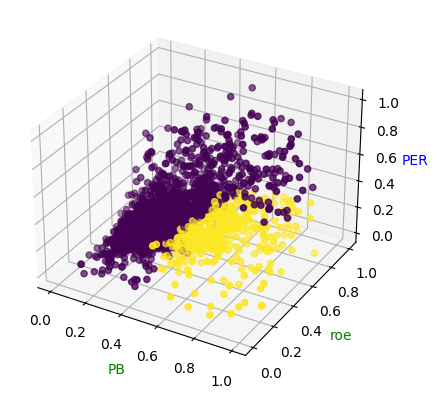

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# X = result['pb'].tolist() # X 轴为 PB 数据 
# Y = result['roe'].tolist()
# Z = result['trade'].tolist() # Z 轴为 股价数据 

ax.set_xlabel('PB', color='g')
ax.set_ylabel('roe', color='g')
# ax.set_zlabel('trade', color='b') # 给三个坐标轴注明
ax.set_zlabel('PER', color='b') # 给三个坐标轴注明

ax.scatter(X['pb'], X['roe'], X['trade'], c=y_kmeans==5)
# ax.scatter(X['pb'], X['roe'], X['per'], c=y_kmeans)

plt.show()

In [16]:
result[y_kmeans == 5].code.values

array(['688698', '688697', '688681', '688609', '688588', '688586',
       '688579', '688575', '688509', '688505', '688488', '688323',
       '688313', '688260', '688222', '688219', '688191', '688182',
       '688177', '688158', '688138', '688127', '688106', '688100',
       '688055', '688033', '605580', '605388', '605300', '605299',
       '605162', '605118', '605116', '605056', '603956', '603927',
       '603920', '603909', '603866', '603855', '603819', '603789',
       '603696', '603655', '603628', '603601', '603598', '603383',
       '603330', '603322', '603317', '603315', '603256', '603239',
       '603213', '603181', '603178', '603177', '603171', '603169',
       '603159', '603115', '603105', '603103', '603099', '603055',
       '603033', '603028', '603016', '603000', '601969', '601899',
       '601702', '601698', '601279', '601208', '601126', '601069',
       '601028', '600956', '600903', '600890', '600869', '600857',
       '600836', '600818', '600815', '600793', '600776', '6007

In [236]:
result.ts_code

75      688981.SH
76      688819.SH
85      688779.SH
97      688722.SH
100     688707.SH
          ...    
4701    600242.SH
4707    600217.SH
4712    600163.SH
4713    600146.SH
4719    600091.SH
Name: ts_code, Length: 2528, dtype: object

In [254]:
result[result['code'] == '000001']['roe']

4619    8.86
Name: roe, dtype: float64

In [250]:
result.columns

Index(['code', 'name_x', 'changepercent', 'trade', 'open', 'high', 'low',
       'settlement', 'volume', 'turnoverratio', 'amount', 'per', 'pb',
       'mktcap', 'nmc', 'ts_code', 'symbol', 'name_y', 'area', 'industry',
       'market', 'list_date', 'name', 'eps', 'eps_yoy', 'bvps', 'roe', 'epcf',
       'net_profits', 'profits_yoy', 'distrib', 'report_date'],
      dtype='object')

In [3]:
result = pd.read_pickle('d:/d.pkl')

In [14]:
result.code.unique().shape

(2395,)

In [5]:
# # 获取股票基本信息，包括 PE、PB 值
# ts.set_token('42731ca565c5d019007ef5cd7db7808757b2ea3fdbfb31d4f7b61444b')
# pro = ts.pro_api()

# df_base = pro.stock_basic() # ts.get_stock_basics()
# # df_base['code'] = df_base.index

# # 获取股票当天数据，包括当前股价
# df_todays = ts.get_today_all()

In [18]:
# df_todays.to_pickle('d:/dd.pkl')

In [25]:
# result = pd.read_pickle('d:/dd.pkl')

In [15]:
result.head()

,code,name_x,changepercent,trade,open,high,low,settlement,volume,turnoverratio,...,name,eps,eps_yoy,bvps,roe,epcf,net_profits,profits_yoy,distrib,report_date
78,688981,中芯国际,2.205,51.92,50.99,52.05,50.99,50.80,10921825,0.58373,...,中芯国际,0.93,82.35,NaN,7.10,NaN,731827.60,137.59,NaN,11-12
79,688819,天能股份,1.305,38.04,37.55,38.16,37.52,37.55,515108,0.40084,...,天能股份,1.11,NaN,NaN,9.55,NaN,106553.89,-27.28,NaN,10-30
81,688799,华纳药厂,0.304,36.29,36.18,36.59,35.76,36.18,200441,1.00346,...,华纳药厂,1.10,NaN,NaN,12.00,NaN,10326.11,13.74,NaN,10-28
86,688787,海天瑞声,-0.288,62.25,62.45,63.35,61.27,62.43,175435,1.92892,...,海天瑞声,0.77,NaN,NaN,5.26,NaN,2565.84,-50.48,NaN,10-30
87,688786,悦安新材,-0.523,45.61,45.79,46.92,45.06,45.85,113140,0.65069,...,悦安新材,0.97,NaN,NaN,10.41,NaN,6568.22,92.05,NaN,10-28


In [27]:
# result[df_todays.code == '399296']

,code,name,changepercent,trade,open,high,low,settlement,volume,turnoverratio,amount,per,pb,mktcap,nmc


In [16]:
ltdxhq = LTdxHq()

In [17]:
# dlist = ltdxhq.stock_list()

In [18]:
# dlist[dlist['code'] == '603636']

In [19]:
# dlist[dlist['code'] == '399296']

In [52]:
ltdxhq = LTdxHq()

indexs = None
dfs = []
for code in result.code.values:
    try:
        df = ltdxhq.get_k_data_daily(code, start='2016-01-01') # 2012-01-01

        if indexs is None:
            indexs = df.index
        else:
            indexs = indexs.union(df.index)

    #     df = df.assign(date = df.index)
    #     df = df.assign(day = df.index.weekday)
    #     df.date = df.date.dt.strftime('%Y-%m-%d')
        df = df.assign(tic = code)
    #     df.index = range(df.shape[0])

        dfs.append(df)
        print('----------- over %s min: %s max: %s -----------' % (code, df.index.min(), df.index.max()))
    except Exception as ex:
#         print(traceback.format_exc())
        print('error code: %s' % code)

for i, df in enumerate(dfs):
    df = df.reindex(indexs)
    df = df.assign(date = df.index)
    df = df.assign(day = df.index.weekday)
    df.index = range(df.shape[0])
    
    dfs[i] = df.ffill()
    
ddf = pd.concat(dfs)
# df.index = range(df.shape[0])

ltdxhq.close()

----------- over 688981 min: 2020-07-16 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688793 min: 2021-07-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688788 min: 2020-10-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688787 min: 2021-08-13 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688786 min: 2021-08-26 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688779 min: 2021-08-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688772 min: 2021-10-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688739 min: 2021-10-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688728 min: 2021-08-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688722 min: 2021-10-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688701 min: 2021-09-16 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688697 min: 2021-09-17 00:00:00 max: 

----------- over 688255 min: 2021-10-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688248 min: 2021-12-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688233 min: 2020-02-21 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688232 min: 2021-11-17 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688229 min: 2020-08-17 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688228 min: 2020-03-27 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688222 min: 2020-04-16 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688221 min: 2020-10-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688219 min: 2020-11-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688218 min: 2019-12-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688217 min: 2021-05-17 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 688216 min: 2021-06-23 00:00:00 max: 

----------- over 605339 min: 2021-05-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605338 min: 2020-10-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605319 min: 2021-06-07 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605318 min: 2020-08-03 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605305 min: 2021-05-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605300 min: 2021-04-30 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605298 min: 2021-03-01 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605296 min: 2021-05-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605288 min: 2020-06-01 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605277 min: 2021-01-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605266 min: 2020-12-01 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 605259 min: 2021-06-15 00:00:00 max: 

----------- over 603881 min: 2017-02-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603880 min: 2017-08-07 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603878 min: 2016-12-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603877 min: 2017-01-09 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603876 min: 2018-04-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603871 min: 2018-02-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603867 min: 2019-06-27 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603866 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603863 min: 2019-06-21 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603861 min: 2016-03-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603860 min: 2017-08-02 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603856 min: 2017-11-06 00:00:00 max: 

----------- over 603599 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603588 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603587 min: 2018-06-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603586 min: 2017-04-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603585 min: 2016-12-14 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603583 min: 2018-09-21 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603580 min: 2017-05-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603579 min: 2017-01-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603577 min: 2016-12-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603569 min: 2016-08-10 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603568 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603567 min: 2016-01-04 00:00:00 max: 

----------- over 603223 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603222 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603220 min: 2018-11-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603219 min: 2021-11-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603218 min: 2016-12-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603217 min: 2019-06-20 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603216 min: 2021-12-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603213 min: 2021-11-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603212 min: 2020-04-30 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603208 min: 2017-02-10 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603203 min: 2016-11-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 603199 min: 2016-01-04 00:00:00 max: 

----------- over 601997 min: 2016-08-16 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601996 min: 2016-03-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601985 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601975 min: 2019-01-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601969 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601968 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601965 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601963 min: 2021-02-05 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601952 min: 2017-05-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601949 min: 2017-08-21 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601939 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601928 min: 2016-01-04 00:00:00 max: 

----------- over 601200 min: 2017-03-31 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601199 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601198 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601188 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601186 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601179 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601177 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601169 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601168 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601166 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601162 min: 2018-10-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 601155 min: 2016-01-04 00:00:00 max: 

----------- over 600877 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600875 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600873 min: 2016-05-26 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600869 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600867 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600866 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600865 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600858 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600857 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600855 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600854 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600853 min: 2016-01-04 00:00:00 max: 

----------- over 600682 min: 2016-01-27 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600681 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600675 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600673 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600668 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600667 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600664 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600663 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600662 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600658 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600655 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600653 min: 2016-01-04 00:00:00 max: 

----------- over 600470 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600469 min: 2016-06-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600468 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600467 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600463 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600461 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600459 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600458 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600456 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600448 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600446 min: 2016-01-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600439 min: 2016-01-04 00:00:00 max: 

----------- over 600252 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600251 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600250 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600246 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600235 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600234 min: 2016-01-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600233 min: 2016-04-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600232 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600230 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600229 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600226 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600223 min: 2016-01-04 00:00:00 max: 

----------- over 600025 min: 2017-12-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600022 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600021 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600020 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600019 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600018 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600017 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600016 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600015 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600009 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600008 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 600007 min: 2016-01-04 00:00:00 max: 

----------- over 301003 min: 2021-06-01 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 301002 min: 2021-06-07 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 301001 min: 2021-05-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 301000 min: 2021-05-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300999 min: 2020-10-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300998 min: 2021-06-02 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300996 min: 2021-06-03 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300995 min: 2021-05-26 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300992 min: 2021-05-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300991 min: 2021-05-20 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300990 min: 2021-05-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300989 min: 2021-05-07 00:00:00 max: 

----------- over 300838 min: 2020-06-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300835 min: 2020-05-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300832 min: 2020-05-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300831 min: 2020-05-07 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300829 min: 2020-04-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300825 min: 2020-03-27 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300824 min: 2020-06-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300823 min: 2020-03-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300822 min: 2020-03-13 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300821 min: 2020-03-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300818 min: 2020-02-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300817 min: 2020-02-18 00:00:00 max: 

----------- over 300643 min: 2017-05-05 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300642 min: 2017-04-21 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300641 min: 2017-04-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300640 min: 2017-04-17 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300639 min: 2017-04-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300638 min: 2017-04-13 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300635 min: 2017-03-31 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300634 min: 2018-03-23 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300633 min: 2017-04-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300632 min: 2017-04-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300631 min: 2017-03-23 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300630 min: 2017-03-28 00:00:00 max: 

----------- over 300477 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300476 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300473 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300468 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300467 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300465 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300464 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300462 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300460 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300459 min: 2016-01-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300458 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300457 min: 2016-01-04 00:00:00 max: 

----------- over 300292 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300291 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300290 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300289 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300288 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300287 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300286 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300285 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300282 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300281 min: 2016-01-06 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300280 min: 2016-02-23 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300279 min: 2016-01-04 00:00:00 max: 

----------- over 300131 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300130 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300129 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300128 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300125 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300123 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300121 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300120 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300119 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300114 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300109 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 300106 min: 2016-01-04 00:00:00 max: 

----------- over 002995 min: 2020-08-05 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002993 min: 2020-08-17 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002992 min: 2020-08-03 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002990 min: 2020-05-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002989 min: 2020-06-10 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002988 min: 2020-05-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002986 min: 2020-06-02 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002985 min: 2020-04-29 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002984 min: 2020-09-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002983 min: 2020-04-28 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002981 min: 2020-04-17 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002980 min: 2020-04-15 00:00:00 max: 

----------- over 002827 min: 2016-12-09 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002826 min: 2016-12-09 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002825 min: 2016-11-29 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002824 min: 2017-01-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002822 min: 2016-11-29 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002820 min: 2016-11-18 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002819 min: 2016-11-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002816 min: 2016-10-25 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002811 min: 2016-09-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002808 min: 2016-08-12 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002806 min: 2016-07-26 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002805 min: 2016-07-07 00:00:00 max: 

----------- over 002644 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002642 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002641 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002639 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002638 min: 2016-01-19 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002637 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002636 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002634 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002632 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002631 min: 2016-04-08 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002628 min: 2016-01-11 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002627 min: 2016-01-04 00:00:00 max: 

----------- over 002479 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002475 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002474 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002472 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002471 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002470 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002469 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002468 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002467 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002465 min: 2016-02-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002463 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002462 min: 2016-01-04 00:00:00 max: 

----------- over 002307 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002303 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002301 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002300 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002299 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002298 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002296 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002293 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002292 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002291 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002290 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002289 min: 2016-01-04 00:00:00 max: 

----------- over 002129 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002126 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002125 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002123 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002122 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002120 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002117 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002116 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002115 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002112 min: 2016-06-15 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002111 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 002108 min: 2016-01-04 00:00:00 max: 

----------- over 000977 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000976 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000975 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000973 min: 2016-02-22 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000971 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000969 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000968 min: 2016-07-07 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000967 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000965 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000963 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000961 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000960 min: 2016-01-04 00:00:00 max: 

----------- over 000732 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000728 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000726 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000722 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000721 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000720 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000717 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000716 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000713 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000711 min: 2016-03-02 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000710 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000709 min: 2016-01-04 00:00:00 max: 

----------- over 000516 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000514 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000513 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000510 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000507 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000506 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000505 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000501 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000498 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000426 min: 2016-03-21 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000423 min: 2016-01-04 00:00:00 max: 2022-06-02 00:00:00 -----------
----------- over 000419 min: 2016-01-04 00:00:00 max: 

In [53]:
ddf.to_pickle('d:/ddf_0606.pkl')

In [11]:
import pymongo
import pandas as pd
import numpy as np
from pymongo import MongoClient

In [20]:
pd.set_option('display.max_columns', None)

In [12]:
client = MongoClient()
db = client['quantaxis']

In [13]:
coll_list = db['stock_info']
stock_info = pd.DataFrame(list(coll_list.find()))

In [22]:
stock_info.head(10)

,_id,market,code,liutongguben,province,industry,updated_date,ipo_date,zongguben,guojiagu,faqirenfarengu,farengu,bgu,hgu,zhigonggu,zongzichan,liudongzichan,gudingzichan,wuxingzichan,gudongrenshu,liudongfuzhai,changqifuzhai,zibengongjijin,jingzichan,zhuyingshouru,zhuyinglirun,yingshouzhangkuan,yingyelirun,touzishouyu,jingyingxianjinliu,zongxianjinliu,cunhuo,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun,meigujingzichan,baoliu2
0,628c35e287b63fdce4d4dfb0,0,000001,1.940552e+10,18,1,20220427,19910403,1.940592e+10,19660000.0,1.013200e+11,4.178800e+11,0.000000e+00,0.000000e+00,5600.000024,5.117949e+13,0.000000e+00,1.156600e+11,5.644000e+10,508679.0,0.000000e+00,0.000000e+00,8.081600e+11,4.061750e+12,4.620700e+11,2.986700e+11,0.000000e+00,1.634000e+11,3.878000e+10,1.471270e+12,8.021701e+11,0.000000e+00,1.618400e+11,1.285000e+11,1.285000e+11,1.648040e+12,17.33,3.0
1,628c35e287b63fdce4d4dfb1,0,000002,9.717553e+09,18,11,20220429,19910129,1.162538e+10,20700000.0,1.292286e+10,6.226410e+11,0.000000e+00,1.901187e+09,0.000000,1.947369e+13,1.608774e+13,1.408112e+11,1.068440e+11,537477.0,1.303928e+13,1.564393e+12,2.059001e+11,2.368704e+12,6.266708e+11,5.083880e+11,5.926496e+10,3.969818e+10,5.751892e+09,-1.325919e+11,-3.514210e+10,1.076340e+13,4.081142e+10,2.786996e+10,1.428994e+10,9.412744e+11,0.00,3.0
2,628c35e287b63fdce4d4dfb2,0,000004,1.163308e+08,18,24,20220517,19910114,1.560030e+08,18650000.0,4.299340e+07,3.653115e+08,0.000000e+00,0.000000e+00,0.000000,1.080484e+10,5.843145e+09,2.311500e+07,3.581650e+08,24239.0,1.398079e+09,1.822000e+06,1.208592e+10,9.351157e+09,1.126370e+08,4.482200e+07,3.430200e+09,-1.309880e+08,-1.388000e+06,-2.841420e+08,-6.374400e+08,2.060410e+08,-1.309880e+08,-1.294660e+08,-1.257160e+08,-4.428938e+09,0.00,3.0
3,628c35e287b63fdce4d4dfb3,0,000005,1.057946e+09,18,39,20220511,19901210,1.058537e+09,23770000.0,8.381020e+07,4.816156e+08,0.000000e+00,0.000000e+00,0.000000,2.366485e+10,1.241113e+10,2.510220e+08,5.429390e+08,95219.0,8.171518e+09,9.997759e+08,6.809547e+09,1.375810e+10,2.925910e+08,2.487620e+08,1.645363e+09,8.386000e+06,2.000000e+08,-1.391640e+08,-4.553220e+08,1.414700e+08,8.476000e+06,6.084000e+06,1.565300e+07,-3.902922e+09,0.00,3.0
4,628c35e287b63fdce4d4dfb4,0,000006,1.349995e+09,18,11,20220427,19920427,1.349995e+09,20700000.0,2.693739e+09,9.182869e+09,0.000000e+00,0.000000e+00,0.000000,2.350920e+11,1.952617e+11,4.197580e+08,0.000000e+00,69549.0,8.890952e+10,5.394298e+09,4.843216e+09,7.690012e+10,3.513921e+09,1.863004e+09,1.931040e+08,5.619840e+08,2.003290e+08,-1.222934e+09,-3.614400e+07,1.622392e+11,5.677890e+08,4.506550e+08,4.443190e+08,3.745056e+10,0.00,3.0
5,628c35e287b63fdce4d4dfb5,0,000007,3.089480e+08,18,10,20220509,19920413,3.464480e+08,20700000.0,-1.289470e+07,1.315511e+08,0.000000e+00,0.000000e+00,0.000000,4.255900e+09,3.006702e+09,4.628920e+08,2.820000e+06,9849.0,1.994451e+09,1.274930e+08,1.570241e+09,9.687050e+08,6.001120e+08,4.981210e+08,1.383380e+08,-1.444700e+07,-7.560000e+05,-6.497700e+07,-8.276900e+07,2.394870e+08,-4.166400e+07,-4.428700e+07,-4.443900e+07,-3.530573e+09,0.00,3.0
6,628c35e287b63fdce4d4dfb6,0,000008,2.693934e+09,7,8,20220523,19920507,2.780795e+09,12370000.0,-8.601032e+08,1.492886e+09,0.000000e+00,0.000000e+00,-199.999996,1.196518e+11,5.691286e+10,3.963458e+09,2.902533e+09,104450.0,5.152554e+10,1.336699e+09,2.788228e+10,5.152826e+10,2.155852e+09,1.259999e+09,2.576615e+10,-4.454400e+08,3.504330e+08,6.252630e+08,-3.380960e+09,1.188128e+10,-4.452320e+08,-5.140210e+08,-5.134010e+08,-2.394761e+09,0.00,3.0
7,628c35e387b63fdce4d4dfb7,0,000009,2.551430e+09,18,43,20220516,19910625,2.579214e+09,28900000.0,1.902703e+09,3.701038e+10,0.000000e+00,0.000000e+00,0.000000,4.089298e+11,2.699715e+11,5.269895e+10,1.186438e+10,267126.0,1.839009e+11,8.029478e+10,1.392174e+10,8.184216e+10,5.683424e+10,4.279927e+10,4.056642e+10,5.362441e+09,7.145040e+08,-4.740780e+09,-6.132865e+09,1.140257e+11,5.344196e+09,4.509616e+09,1.651342e+09,3.912476e+10,0.00,3.0
8,628c35e387b63fdce4d4dfb8,0,000010,5.221715e+08

In [32]:
columns = ['code', 
            'liutongguben', 
            'zongguben', 
            'guojiagu', 
            'faqirenfarengu', 
            'farengu', 
            'zongzichan', 
            'liudongzichan', 
            'gudingzichan', 
            'wuxingzichan', 
            'liudongfuzhai', 
            'changqifuzhai', 
            'zibengongjijin', 
            'jingzichan', 
            'zhuyingshouru', 
            'zhuyinglirun', 
            'yingshouzhangkuan', 
            'yingyelirun', 
            'touzishouyu', 
            'jingyingxianjinliu', 
            'zongxianjinliu', 
            'lirunzonghe', 
            'shuihoulirun', 
            'jinglirun', 
            'weifenpeilirun']

norm_columns = ['liutongguben', 
            'zongguben', 
            'guojiagu', 
            'faqirenfarengu', 
            'farengu', 
            'zongzichan', 
            'liudongzichan', 
            'gudingzichan', 
            'wuxingzichan', 
            'liudongfuzhai', 
            'changqifuzhai', 
            'zibengongjijin', 
            'jingzichan', 
            'zhuyingshouru', 
            'zhuyinglirun', 
            'yingshouzhangkuan', 
            'yingyelirun', 
            'touzishouyu', 
            'jingyingxianjinliu', 
            'zongxianjinliu', 
            'lirunzonghe', 
            'shuihoulirun', 
            'jinglirun', 
            'weifenpeilirun']

In [60]:
ss = stock_info[columns]

In [61]:
ss

,code,liutongguben,zongguben,guojiagu,faqirenfarengu,farengu,zongzichan,liudongzichan,gudingzichan,wuxingzichan,liudongfuzhai,changqifuzhai,zibengongjijin,jingzichan,zhuyingshouru,zhuyinglirun,yingshouzhangkuan,yingyelirun,touzishouyu,jingyingxianjinliu,zongxianjinliu,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun
0,000001,1.940552e+10,1.940592e+10,19660000.0,1.013200e+11,4.178800e+11,5.117949e+13,0.000000e+00,1.156600e+11,5.644000e+10,0.000000e+00,0.000000e+00,8.081600e+11,4.061750e+12,4.620700e+11,2.986700e+11,0.000000e+00,1.634000e+11,3.878000e+10,1.471270e+12,8.021701e+11,1.618400e+11,1.285000e+11,1.285000e+11,1.648040e+12
1,000002,9.717553e+09,1.162538e+10,20700000.0,1.292286e+10,6.226410e+11,1.947369e+13,1.608774e+13,1.408112e+11,1.068440e+11,1.303928e+13,1.564393e+12,2.059001e+11,2.368704e+12,6.266708e+11,5.083880e+11,5.926496e+10,3.969818e+10,5.751892e+09,-1.325919e+11,-3.514210e+10,4.081142e+10,2.786996e+10,1.428994e+10,9.412744e+11
2,000004,1.163308e+08,1.560030e+08,18650000.0,4.299340e+07,3.653115e+08,1.080484e+10,5.843145e+09,2.311500e+07,3.581650e+08,1.398079e+09,1.822000e+06,1.208592e+10,9.351157e+09,1.126370e+08,4.482200e+07,3.430200e+09,-1.309880e+08,-1.388000e+06,-2.841420e+08,-6.374400e+08,-1.309880e+08,-1.294660e+08,-1.257160e+08,-4.428938e+09
3,000005,1.057946e+09,1.058537e+09,23770000.0,8.381020e+07,4.816156e+08,2.366485e+10,1.241113e+10,2.510220e+08,5.429390e+08,8.171518e+09,9.997759e+08,6.809547e+09,1.375810e+10,2.925910e+08,2.487620e+08,1.645363e+09,8.386000e+06,2.000000e+08,-1.391640e+08,-4.553220e+08,8.476000e+06,6.084000e+06,1.565300e+07,-3.902922e+09
4,000006,1.349995e+09,1.349995e+09,20700000.0,2.693739e+09,9.182869e+09,2.350920e+11,1.952617e+11,4.197580e+08,0.000000e+00,8.890952e+10,5.394298e+09,4.843216e+09,7.690012e+10,3.513921e+09,1.863004e+09,1.931040e+08,5.619840e+08,2.003290e+08,-1.222934e+09,-3.614400e+07,5.677890e+08,4.506550e+08,4.443190e+08,3.745056e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,688799,1.997500e+07,9.380000e+07,12270000.0,3.347745e+08,2.371487e+09,1.919244e+10,1.222146e+10,4.683534e+09,8.326680e+08,2.784717e+09,7.142700e+08,8.503382e+09,1.513556e+10,2.919712e+09,9.787910e+08,1.304007e+09,3.994400e+08,2.944200e+07,1.445500e+08,-1.570980e+08,3.984570e+08,3.409130e+08,3.409130e+08,5.225182e+09
4732,688800,2.295000e+07,1.080000e+08,12390000.0,1.634786e+08,1.481466e+09,1.764223e+10,1.451649e+10,1.565279e+09,5.223460e+08,6.962662e+09,3.848000e+06,5.143609e+09,1.052723e+10,3.619869e+09,2.715925e+09,4.688876e+09,6.378450e+08,8.188000e+06,-4.090400e+08,-1.256561e+09,6.377650e+08,5.576970e+08,5.576340e+08,4.010198e+09
4733,688819,1.285071e+08,9.721000e+08,12380000.0,4.119273e+09,7.259496e+10,2.865571e+11,2.056568e+11,4.762570e+10,9.942470e+09,1.413085e+11,4.550961e+09,5.753494e+10,1.270908e+11,8.518375e+10,7.064862e+10,1.560579e+10,4.751818e+09,2.479810e+08,-2.785055e+10,-2.294362e+10,4.854113e+09,4.250928e+09,4.380978e+09,5.550200e+10
4734,688981,1.871038e+09,7.909369e+09,12390000.0,1.032154e+10,7.291961e+10,2.381059e+12,1.012423e+12,6.777999e+11,2.748555e+10,2.899598e+11,5.504229e+11,9.811040e+11,1.122484e+12,1.185401e+11,6.973532e+10,4.920151e+10,3.649604e+10,1.127790e+09,1.041379e+11,-1.579265e+11,3.650392e+10,3.618723e+10,2.843451e+10,2.163776e+11


In [63]:
# standard_transformer = Pipeline(steps=[
#         ('standard', StandardScaler())])

# minmax_transformer = Pipeline(steps=[
#         ('minmax', MinMaxScaler())])


# preprocessor = ColumnTransformer(
#         remainder='passthrough', #passthough features not listed
#         transformers=[
# #             ('std', standard_transformer , ['z']),
#             ('mm', minmax_transformer , norm_columns)
#         ])

# X = preprocessor.fit(ss)

scaler = MinMaxScaler()
# scaler.fit(ss[norm_columns])
# X = pd.DataFrame(scaler.transform(ss[norm_columns]), columns=columns)
ss.loc[:,norm_columns] = scaler.fit_transform(ss[norm_columns])

d:\soft\python\python37\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [64]:
ss

,code,liutongguben,zongguben,guojiagu,faqirenfarengu,farengu,zongzichan,liudongzichan,gudingzichan,wuxingzichan,liudongfuzhai,changqifuzhai,zibengongjijin,jingzichan,zhuyingshouru,zhuyinglirun,yingshouzhangkuan,yingyelirun,touzishouyu,jingyingxianjinliu,zongxianjinliu,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun
0,000001,0.064840,0.054449,0.510852,0.177727,0.072478,0.137222,0.000000,0.016949,0.022955,0.000000,0.003898,0.805181,0.123665,0.060100,0.047892,0.000000,0.223736,0.215624,0.293910,0.228361,0.219081,0.224965,0.218520,0.124306
1,000002,0.032469,0.032618,0.565908,0.081578,0.107993,0.052211,0.889001,0.020635,0.043455,0.981466,0.522258,0.678664,0.073038,0.081202,0.081520,0.029047,0.120429,0.163928,0.187083,0.165218,0.119495,0.125332,0.103774,0.084262
2,000004,0.000389,0.000438,0.457385,0.067568,0.000063,0.000027,0.000323,0.000003,0.000146,0.000105,0.003899,0.637949,0.002487,0.000878,0.000007,0.001681,0.087166,0.154923,0.195895,0.167820,0.085806,0.097610,0.089291,0.030680
3,000005,0.003535,0.002970,0.728428,0.067613,0.000084,0.000061,0.000686,0.000037,0.000221,0.000615,0.004229,0.636841,0.002619,0.000901,0.000040,0.000806,0.087282,0.155238,0.195905,0.167834,0.085921,0.097745,0.089433,0.030710
4,000006,0.004511,0.003788,0.565908,0.070452,0.001593,0.000628,0.010790,0.000062,0.000000,0.006692,0.005686,0.636428,0.004507,0.001314,0.000299,0.000095,0.087745,0.155239,0.195833,0.167866,0.086381,0.098185,0.089863,0.033053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4731,688799,0.000067,0.000263,0.119640,0.067886,0.000411,0.000049,0.000675,0.000686,0.000339,0.000210,0.004135,0.637197,0.002660,0.001238,0.000157,0.000639,0.087609,0.154971,0.195924,0.167856,0.086242,0.098076,0.089759,0.031227
4732,688800,0.000077,0.000303,0.125993,0.067699,0.000257,0.000045,0.000802,0.000229,0.000212,0.000524,0.003899,0.636491,0.002522,0.001327,0.000435,0.002298,0.087808,0.154938,0.195887,0.167774,0.086439,0.098291,0.089977,0.031159
4733,688819,0.000429,0.002728,0.125463,0.072002,0.012591,0.000766,0.011365,0.006979,0.004044,0.010636,0.005406,0.647497,0.006008,0.011784,0.011329,0.007649,0.091244,0.155313,0.194059,0.166138,0.089908,0.101947,0.093818,0.034076
4734,688981,0.006252,0.022192,0.125993,0.078748,0.012647,0.006382,0.055946,0.099326,0.011179,0.021825,0.186280,0.841511,0.035773,0.016060,0.011182,0.024115,0.117754,0.156690,0.202850,0.155959,0.115950,0.133567,0.117985,0.043191


In [69]:
ss.loc[:1,norm_columns].cov().corr()

,liutongguben,zongguben,guojiagu,faqirenfarengu,farengu,zongzichan,liudongzichan,gudingzichan,wuxingzichan,liudongfuzhai,changqifuzhai,zibengongjijin,jingzichan,zhuyingshouru,zhuyinglirun,yingshouzhangkuan,yingyelirun,touzishouyu,jingyingxianjinliu,zongxianjinliu,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun
liutongguben,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
zongguben,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
guojiagu,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
faqirenfarengu,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
farengu,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
zongzichan,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
liudongzichan,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
gudingzichan,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
wuxingzichan,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
liudongfuzhai,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [62]:
ss[norm_columns].cov().corr()

,liutongguben,zongguben,guojiagu,faqirenfarengu,farengu,zongzichan,liudongzichan,gudingzichan,wuxingzichan,liudongfuzhai,changqifuzhai,zibengongjijin,jingzichan,zhuyingshouru,zhuyinglirun,yingshouzhangkuan,yingyelirun,touzishouyu,jingyingxianjinliu,zongxianjinliu,lirunzonghe,shuihoulirun,jinglirun,weifenpeilirun
liutongguben,1.000000,0.999988,0.999329,0.999944,0.996977,0.999846,0.719178,0.996303,0.965498,0.733071,0.979936,0.999855,0.999981,0.995381,0.991266,0.729745,0.999979,0.999804,0.999117,0.999071,0.999979,0.999979,0.999967,0.999951
zongguben,0.999988,1.000000,0.999269,0.999980,0.996604,0.999912,0.716168,0.995994,0.964308,0.730096,0.979039,0.999827,0.999994,0.994933,0.990648,0.726650,0.999981,0.999770,0.999262,0.999209,0.999982,0.999988,0.999989,0.999943
guojiagu,0.999329,0.999269,1.000000,0.999218,0.996966,0.999184,0.732788,0.995111,0.967544,0.745850,0.982943,0.999422,0.999269,0.995267,0.991474,0.740200,0.999249,0.998829,0.997941,0.997990,0.999251,0.999245,0.999208,0.999209
faqirenfarengu,0.999944,0.999980,0.999218,1.000000,0.996203,0.999968,0.712962,0.995457,0.962900,0.726884,0.978083,0.999804,0.999973,0.994419,0.989963,0.723317,0.999948,0.999750,0.999395,0.999336,0.999950,0.999964,0.999979,0.999889
farengu,0.996977,0.996604,0.996966,0.996203,1.000000,0.995567,0.766398,0.998553,0.982145,0.779635,0.991606,0.996905,0.996643,0.999771,0.998472,0.778499,0.996858,0.997213,0.993543,0.993538,0.996843,0.996742,0.996518,0.997033
zongzichan,0.999846,0.999912,0.999184,0.999968,0.995567,1.000000,0.709252,0.994751,0.961102,0.723178,0.976883,0.999740,0.999896,0.993623,0.988921,0.719198,0.999845,0.999588,0.999490,0.999435,0.999849,0.999874,0.999907,0.999760
liudongzichan,0.719178,0.716168,0.732788,0.712962,0.766398,0.709252,1.000000,0.757061,0.864331,0.999466,0.841886,0.719703,0.716712,0.775729,0.795919,0.994247,0.718189,0.718171,0.696461,0.697782,0.718094,0.717217,0.715422,0.720096
gudingzichan,0.996303,0.995994,0.995111,0.995457,0.998553,0.994751,0.757061,1.000000,0.980643,0.771072,0.988372,0.995646,0.996072,0.998717,0.997074,0.770827,0.996298,0.996189,0.993161,0.993100,0.996280,0.996158,0.995950,0.996606
wuxingzichan,0.965498,0.964308,0.967544,0.962900,0.982145,0.961102,0.864331,0.980643,1.000000,0.875815,0.995817,0.965353,0.964470,0.985293,0.990458,0.878160,0.965134,0.965706,0.955757,0.955954,0.965084,0.964728,0.964011,0.965882
liudongfuzhai,0.733071,0.730096,0.745850,0.726884,0.779635,0.723178,0.999466,0.771072,0.875815,1.000000,0.852834,0.733594,0.730595,0.788894,0.808743,0.996070,0.732047,0.732209,0.710594,0.711839,0.731951,0.731086,0.729313,0.733925
